# The Interface Functions and Solution Container


In this tutorial, we demonstrate how to use the interface functions of the `dcegm` package to visualize the solved model and explain the structure of the solution container, which is the output of the `solve` function.

The interface functions are designed to simplify interaction with the `dcegm` package. The interface functions explained here are:
- `policy_for_state_choice_vec`: Returns the policy function for a given state and choice after solving the model.
- `value_for_state_choice_vec`: Returns the value function for a given state and choice after solving the model.
- `get_state_choice_index_per_discrete_state_and_choice`: Returns the index of a particular state and choice in the solution container.

The solve function we will use is:
- `get_solve_func_for_model`: Returns the solve function for a given model.


## Importing the necessary packages and functions

In [1]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import dcegm
from dcegm.toy_models.example_model_functions import load_example_model_functions

# set the jax_enable_x64 configuration option
jax.config.update("jax_enable_x64", True)

# set the style analogous to the Figure 4 in the paper
line_styles = [
    {
        "color": "black",
        "marker": "o",
        "linestyle": "None",
        "markersize": 5,
    },  # Black dots
    {"color": "red", "linestyle": "-"},  # Red solid line
    {"color": "black", "linestyle": "--"},  # Black dashed line
    {"color": "black", "linestyle": "-."},  # Black dash-dot line
    {"color": "red", "linestyle": ":"},  # Red dotted line
]

## Model Specification

We consider a general formulation of the consumption-savings and retirement problem following Iskhakov et al. (2017). The model assumes constant relative risk aversion (CRRA) utility and incorporates the disutility of work. It is defined as follows

$$
\max _{\{c_t, d_t\}_{t=1}^T} \sum_{t=1}^T \beta^t\left(\frac{c_t^{1-\rho}-1}{1-\rho}-\delta_t(1 - d_t)+\sigma_{\varepsilon}\varepsilon(d_t)\right) = \sum_{t=1}^T \beta^t u(c_t,d_t)
$$

where
- $\rho$ is the CRRA coefficient,  
- $\delta \geq 0$ represents the disutility of work,  
- $\varepsilon \sim EV(0,1)$ is a choice-specific taste shock following an extreme-value distribution,  
- $\sigma_{\varepsilon}$ is the scale parameter of the extreme-value distribution,  
- $T$ is the planning horizon,  
- $\beta$ is the discount factor.  

The goal is to maximize discounted lifetime utility. We define 
- $d_t = 1$ as retirement,  
- $d_t = 0$ as continued work.  

For $\rho = 1$, the CRRA utility function simplifies using L'Hôpital's rule, as follows

$$
\lim_{\rho \to 1} \frac{c_t^{1-\rho}-1}{1-\rho} = \log(c_t)
$$

For simplicity, we assume that retirement is an absorbing state, i.e., once an individual retires, they cannot return to work.

### Budget Constraint  

The maximization problem is subject to period-specific borrowing constraints

$$
c_t \leq M_t
$$

where the consumer's available resources at the beginning of period $t$ are given by

$$
M_t = R(M_{t-1} - c_{t-1}) + y d_{t-1}
$$

Here:  
- $R$ is the fixed, non-stochastic gross interest rate,  
- $y$ represents period-invariant labor income for workers.

At the start of each period, individuals decide on their consumption and whether to enter (absorbing) retirement. Interest earnings and labor income are received at the end of the period. 


### Setting up the model `params`, `model_specs`, and `model_config`

See practitioner guide for more details on how to set up the model parameters, specifications, and configurations. The model is set up as follows:

In [2]:
# set the model parameters
params = {
    "delta": 1.00,  # disutility of work
    "constant": np.log(20.0),  # age-independent labor income
    "rho": 1,  # coefficient of relative risk aversion
    "interest_rate": 0.0,  # interest rate
    "taste_shock_scale": 2e-16,  # taste shock (scale) parameter
    "income_shock_std": 0.0,  # standard deviation of income shock
    "income_shock_mean": 0.0,  # mean of income shock
    ## Parameters specific to the more complex dc-egm retirement model -- can be ignored for now ##
    "exp": 0.00,  # return to experience
    "exp_squared": 0.0,  # return to experience squared
    "consumption_floor": 0.0,  # consumption floor / retirement safety net
}
model_specs = {
    "discount_factor": 0.98,  # discount factor
    "min_age": 20,  # minimum age
    "n_choices": 2,  # number of choices
}
model_config = {
    "n_periods": 43,  # number of periods in the model (e.g. 43 for t = 0, 1, ..., 42)
    "choices": [0, 1],  # choices for the model
    "continuous_states": {
        "assets_end_of_period": np.linspace(
            0,
            150,
            500,
        )
    },
    "n_quad_points": 1,  # number of quadrature points for the income shock
    "tuning_params": {  # tuning parameters for the model, ignore for now
        "fues_n_points_to_scan": 20,  # number of points to scan for the fues
        "fues_jump_thresh": 8,  # threshold for the fues jump
    },
}

# load the model functions for the exact functions see the example model file
model_funcs = load_example_model_functions("dcegm_paper")

### Solving the Model

To set up a model we initialize a `model` object using the model class. This is one of the 2 main objects in the `dcegm` package. The other is the `solution` object, which is used to store the solution of a model. A model object contains all the information needed to solve the model, if given a parameters dictionary.

In [3]:
# set up the model structure and process the model functions, notice how this is independent of the params dictionary that contains the model parameters.
model = dcegm.setup_model(
    model_config=model_config,
    model_specs=model_specs,
    state_space_functions=model_funcs["state_space_functions"],
    utility_functions=model_funcs["utility_functions"],
    utility_functions_final_period=model_funcs["utility_functions_final_period"],
    budget_constraint=model_funcs["budget_constraint"],
)

# solve the model for the given parameters
model_solved = model.solve(params)

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.



After solving the model, we can use the interface functions to visualize the solution and understand the structure of the solution container. We will want to visualize the policy and value functions for a given state and choice. For this we will need access to the following information:
- `value`: An array of values of the value function for a given state and choice.
- `policy`: An array of policies for a given state and choice.
- `asset_grid`: An array of beginning-of-period asset levels for a given state and choice on which the value and policy functions are defined.

A state in this particular model is defined by the period, as well as the lagged choice to retire or not. The choice is the decision to retire at the beginning of this period or not. For example, consider a worker who continues working in period T-5. First, we define a dictionary `state_dict` containing the state and lagged choice of interest, then use the `get_solution_for_discrete_state_choice` method of our solution object to obtain the solution for this state and choice.

(466,) (466,) (466,)
         Wealth  Consumption      Value
0      0.000000     0.000000  10.509786
1     20.408163    20.408163  12.315526
2     21.015500    20.714899  12.345064
3     21.525343    20.924141  12.369494
4     21.980861    21.079058  12.391198
..          ...          ...        ...
461  184.651857    35.854262  19.149629
462  185.016309    35.918112  19.159784
463  185.380760    35.981963  19.169922
464  185.745212    36.045813  19.180043
465  186.109664    36.109664  19.190144

[466 rows x 3 columns]


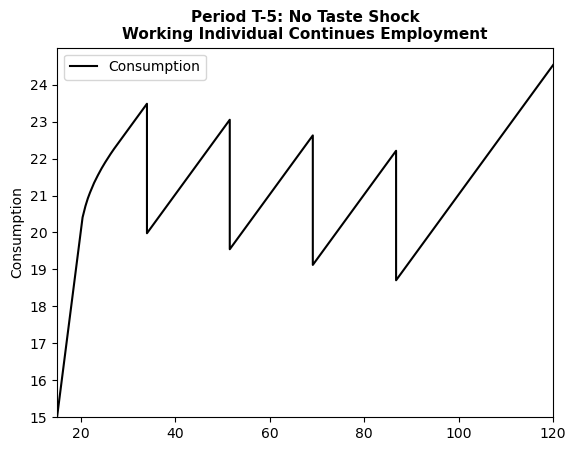

In [4]:
state_dict = {
    "period": 37,  # since we have 43 periods, starting from 0, period 37 is t = 38 so we look at T-5
    "lagged_choice": 0,  # choice in the previous period d_{t-1}
}
choice = 0  # choice in the current period d_t
endog_grid, value, consumption = model_solved.get_solution_for_discrete_state_choice(
    state_dict, choice
)  # choice = 0 means working


# all three objects have the same shape, they are all 1D arrays
print(consumption.shape, value.shape, endog_grid.shape)

# we can look at a table of the values e.g. using pandas
df = pd.DataFrame(
    {
        "Wealth": endog_grid,
        "Consumption": consumption,
        "Value": value,
    }
)
print(df)  # display the first 10 rows of the dataframe

# we can also plot these functions
plt.plot(endog_grid, consumption, label="Consumption", color="black")
plt.xlim([15, 120])
plt.ylim([15, 25])
plt.yticks(np.arange(15, 25, 1))
plt.ylabel("Consumption")
plt.title(
    "Period T-5: No Taste Shock\nWorking Individual Continues Employment",
    fontsize=11,
    fontweight="bold",
)
plt.legend()
plt.show()

## Replicating Figure 4 (a) in Iskhakov et al. (2017)

We now have all the tools necessary to replicate Figure 4 from Iskhakov et al. (2017). Figure (a) shows the policy functions for a worker who continues working in period T-5 for different levels of the taste shock scale parameter $\lambda \in \{2 \times 10^{-16}, 0.01, 0.05, 0.10, 0.15\}$.

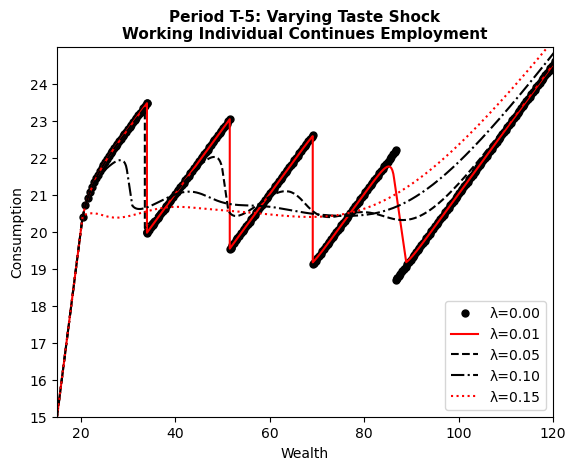

In [5]:
# Define state and choice for the plot
state_dict = {
    "period": 37,  # Perioid T-5
    "lagged_choice": 0,  # working in the previous period
}
choice = 0  # continuing to work

# solve the model for different taste shock scales
for k, taste_shock_scale in enumerate([2e-16, 0.01, 0.05, 0.10, 0.15]):
    params["taste_shock_scale"] = taste_shock_scale
    model_solved = model.solve(params)
    endog_grid, value, consumption = (
        model_solved.get_solution_for_discrete_state_choice(state_dict, choice)
    )
    plt.plot(
        endog_grid,
        consumption,
        label=f"λ={taste_shock_scale:.2f}",
        **line_styles[k],
    )

plt.xlim([15, 120])
plt.ylim([15, 25])
plt.yticks(np.arange(15, 25, 1))
plt.ylabel("Consumption")
plt.title(
    "Period T-5: Varying Taste Shock\nWorking Individual Continues Employment",
    fontsize=11,
    fontweight="bold",
)
plt.xlabel("Wealth")
plt.legend()
plt.show()

We can also solve a slightly more complex model with income uncertainty, as in Iskhakov et al. (2017), by specifying `income_shock_std` ($\sigma$) and `income_shock_mean` ($\mu$) in the `params` dictionary. Specifically, the paper assumes income is $y_t=y \eta_t$, where $\eta_t$ is a log-normally distributed multiplicative idiosyncratic income shock: $\log \eta_t \sim \mathcal{N}\left(\mu, \sigma^2\right)$.

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.



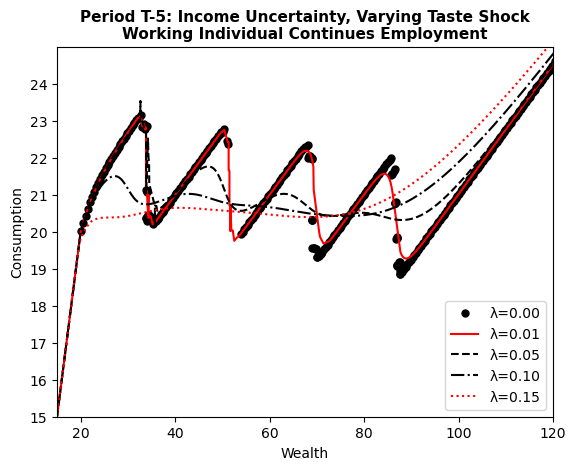

In [16]:
# set the income uncertainty parameters analogous to the Figure 4 (b) in the paper
params["income_shock_std"] = np.sqrt(0.005)
params["income_shock_mean"] = -0.005 / 2

# Define state and choice for the plot
state_dict = {
    "period": 37,  # Perioid T-5
    "lagged_choice": 0,  # working in the previous period
}
choice = 0  # continuing to work

model_config = {
    "n_periods": 43,  # number of periods in the model (e.g. 43 for t = 0, 1, ..., 42)
    "choices": [0, 1],  # choices for the model
    "continuous_states": {
        "assets_end_of_period": np.linspace(
            0,
            150,
            500,
        )
    },
    "n_quad_points": 5,  # number of quadrature points for the income shock
    "tuning_params": {  # tuning parameters for the model, ignore for now
        "fues_n_points_to_scan": 20,  # number of points to scan for the fues
        "fues_jump_thresh": 5,  # threshold for the fues jump
    },
}

model = dcegm.setup_model(
    model_config=model_config,
    model_specs=model_specs,
    state_space_functions=model_funcs["state_space_functions"],
    utility_functions=model_funcs["utility_functions"],
    utility_functions_final_period=model_funcs["utility_functions_final_period"],
    budget_constraint=model_funcs["budget_constraint"],
)

# solve the model for different taste shock scales with income uncertainty and plot the consumption policy function
for k, taste_shock_scale in enumerate([2e-16, 0.01, 0.05, 0.10, 0.15]):
    params["taste_shock_scale"] = taste_shock_scale
    model_solved = model.solve(params)
    endog_grid, value, policy = model_solved.get_solution_for_discrete_state_choice(
        state_dict, choice
    )

    # sort idx by wealth for plotting
    idx = np.argsort(endog_grid)
    endog_grid = endog_grid[idx]
    policy = policy[idx]

    plt.plot(
        endog_grid,
        policy,
        label=f"λ={taste_shock_scale:.2f}",
        **line_styles[k],
    )

plt.xlim([15, 120])
plt.ylim([15, 25])
plt.yticks(np.arange(15, 25, 1))
plt.ylabel("Consumption")
plt.title(
    "Period T-5: Income Uncertainty, Varying Taste Shock\nWorking Individual Continues Employment",
    fontsize=11,
    fontweight="bold",
)
plt.xlabel("Wealth")
plt.legend()
plt.show()